# Regression in PySpark's MLlib Project

Now it's time to put what you've learned to into action with a REAL project! 

You have been hired as a consultant to a cement production company who wants to be able to improve their customer experience around a number of areas like being able to provide recommendations to cusomters on optimal amounts of certian ingredients in the cement making process and perhaps even create an application where users can input their own values and received a predicted cement strength!

I have provided a list of question below to help guide you through this project but feel free to deviate and make this project your own! But first, a bit about this dataset.

### About this dataset 
This dataset contains 1030 instances of concrete samples, containing 9 attributes (8 continuous and 1 discreate), and 1 continuous quantitative output variable. There are no missing attribute values.

### Attribute Information:

Given are the variable name, variable type, the measurement unit and a brief description. The concrete compressive strength is the outcome variable. The order of this listing corresponds to the order of numerals along the rows of the database.

Name -- Data Type -- Measurement -- Description

- Cement -- quantitative -- kg in a m3 mixture -- Input Variable 
- Blast Furnace Slag -- quantitative -- kg in a m3 mixture -- Input Variable 
- Fly Ash -- quantitative -- kg in a m3 mixture -- Input Variable 
- Water -- quantitative -- kg in a m3 mixture -- Input Variable 
- Superplasticizer -- quantitative -- kg in a m3 mixture -- Input Variable 
- Coarse Aggregate -- quantitative -- kg in a m3 mixture -- Input Variable 
- Fine Aggregate -- quantitative -- kg in a m3 mixture -- Input Variable 
- Age -- quantitative -- Day (1~365) -- Input Variable 
- Concrete compressive strength -- quantitative -- MPa -- Output Variable

**Source:** https://www.kaggle.com/maajdl/yeh-concret-data

**Dataset Name:** Concrete_Data.csv

In [1]:
# First let's create our PySpark instance
# import findspark
# findspark.init()

import pyspark  # only run after findspark.init()
from pyspark.sql import SparkSession

# May take awhile locally
spark = SparkSession.builder.appName("Regression_Project").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")
spark

22/10/12 11:46:13 WARN Utils: Your hostname, masoud-ubuntu resolves to a loopback address: 127.0.1.1; using 192.168.7.139 instead (on interface wlp2s0)
22/10/12 11:46:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/12 11:46:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
You are working with 1 core(s)


**Let's start by reading in our datasets**

In [11]:
# For data prep
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import StringType, IntegerType, FloatType
from pyspark.sql.functions import skewness, when, log, exp, col, min, array_min, array
from pyspark.ml.feature import StringIndexer, MinMaxScaler

# To check for multicolinearity
from pyspark.ml.stat import Correlation

# For training and evaluation
from pyspark.ml.regression import (
    LinearRegression,
    DecisionTreeRegressor,
    GBTRegressor,
    RandomForestRegressor,
)
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [3]:
path = "Datasets/"
df = spark.read.csv(path + "Concrete_Data.csv", inferSchema=True, header=True)

**View data**

In [4]:
df.limit(6).toPandas()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03


**And of course the schema :)**

In [5]:
df.printSchema()

root
 |-- cement: double (nullable = true)
 |-- slag: double (nullable = true)
 |-- flyash: double (nullable = true)
 |-- water: double (nullable = true)
 |-- superplasticizer: double (nullable = true)
 |-- coarseaggregate: double (nullable = true)
 |-- fineaggregate: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- csMPa: double (nullable = true)



**Doulbe check to see if there are any missing values**

Let's go ahead and drop any missing values for the sake of simplicity for this lecture as we have already covered the alternatives in subsequent lectures. 

In [6]:
# drop missing data
drop = df.na.drop()
print("before dropping missings:", df.count())
print("after dropping missings", drop.count())

before dropping missings: 1030
after dropping missings 1030


All good!

## 1. Which features are the strongest predictors of cement strength?

Build your own ML model to figure this one out! This would be good information to give to our client so the sales reps can focus their efforts on certain ingredients to provide recommendations on. For example, if our clients had a customer that was struggling with their cement breaking, we could trouble shoot with them by starting with the factors that we know are important.

So in order to do this, we first need to format our data and create a model!

## Format Data 

Remember that MLlib requires all input columns of your dataframe to be vectorized. Good thing we created an awesome function to do that in the lectures, so we can simply copy and pasted that here!

In [16]:
def MLRegressDFPrep(
    df, input_columns, dependent_var, treat_outliers=True, treat_neg_values=True
):

    renamed = df.withColumnRenamed(dependent_var, "label")

    # Make sure dependent variable is numeric and change if it's not
    if renamed.schema["label"].dataType != IntegerType():
        renamed = renamed.withColumn("label", renamed["label"].cast(FloatType()))

    # Convert all string type data in the input column list to numeric
    # Otherwise the Algorithm will not be able to process it
    numeric_inputs = []
    string_inputs = []
    for column in input_columns:
        if renamed.schema[column].dataType == StringType():
            new_col_name = column + "_num"
            string_inputs.append(new_col_name)
        else:
            numeric_inputs.append(column)
            indexed = renamed

    if len(string_inputs) != 0:  # If the datafraem contains string types
        for column in input_columns:
            if renamed.schema[column].dataType == StringType():
                indexer = StringIndexer(inputCol=column, outputCol=column + "_num")
                indexed = indexer.fit(renamed).transform(renamed)
    else:
        indexed = renamed

    if treat_outliers == True:
        print("Correcting for non normality now!")
        # empty dictionary d
        d = {}
        # Create a dictionary of quantiles
        for col in numeric_inputs:
            d[col] = indexed.approxQuantile(
                col, [0.01, 0.99], 0.25
            )  # if you want to make it go faster increase the last number
        # Now fill in the values
        for col in numeric_inputs:
            skew = indexed.agg(skewness(indexed[col])).collect()  # check for skewness
            skew = skew[0][0]
            # This function will floor, cap and then log+1 (just in case there are 0 values)
            if skew > 1:
                indexed = indexed.withColumn(
                    col,
                    log(
                        when(df[col] < d[col][0], d[col][0])
                        .when(indexed[col] > d[col][1], d[col][1])
                        .otherwise(indexed[col])
                        + 1
                    ).alias(col),
                )
                print(
                    col + " has been treated for positive (right) skewness. (skew =)",
                    skew,
                    ")",
                )
            elif skew < -1:
                indexed = indexed.withColumn(
                    col,
                    exp(
                        when(df[col] < d[col][0], d[col][0])
                        .when(indexed[col] > d[col][1], d[col][1])
                        .otherwise(indexed[col])
                    ).alias(col),
                )
                print(
                    col + " has been treated for negative (left) skewness. (skew =",
                    skew,
                    ")",
                )

    # Produce a warning if there are negative values in the dataframe that Naive Bayes cannot be used.
    # Note: we only need to check the numeric input values since anything that is indexed won't have negative values
    minimums = df.select(
        [min(c).alias(c) for c in df.columns if c in numeric_inputs]
    )  # Calculate the mins for all columns in the df
    min_array = minimums.select(
        array(numeric_inputs).alias("mins")
    )  # Create an array for all mins and select only the input cols
    df_minimum = min_array.select(
        array_min(min_array.mins)
    ).collect()  # Collect golobal min as Python object
    df_minimum = df_minimum[0][0]  # Slice to get the number itself

    features_list = numeric_inputs + string_inputs
    assembler = VectorAssembler(inputCols=features_list, outputCol="features")
    output = assembler.transform(indexed).select("features", "label")

    #     final_data = output.select('features','label') #drop everything else

    # Now check for negative values and ask user if they want to correct that?
    if df_minimum < 0:
        print(" ")
        print(
            "WARNING: The Naive Bayes Regressor will not be able to process your dataframe as it contains negative values"
        )
        print(" ")

    if treat_neg_values == True:
        print(
            "You have opted to correct that by rescaling all your features to a range of 0 to 1"
        )
        print(" ")
        print("Rescaling the dataframe....")
        scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

        # Compute summary statistics and generate MinMaxScalerModel
        global scalerModel
        scalerModel = scaler.fit(output)

        # rescale each feature to range [min, max].
        scaled_data = scalerModel.transform(output)
        final_data = scaled_data.select("label", "scaledFeatures")
        final_data = final_data.withColumnRenamed("scaledFeatures", "features")
        print("Done!")

    else:
        print(
            "You have opted not to correct that therefore you will not be able to use to Naive Bayes Regressor"
        )
        print("We will return the dataframe unscaled.")
        final_data = output

    return final_data

And apply it

In [17]:
input_columns = df.columns[:-1]  # all except the last one
dependent_var = df.columns[-1]  # The last column

final_data = MLRegressDFPrep(df, input_columns, dependent_var)
final_data.show(5)

Correcting for non normality now!
age has been treated for positive (right) skewness. (skew =) 3.2644145354168086 )
You have opted to correct that by rescaling all your features to a range of 0 to 1
 
Rescaling the dataframe....
Done!
+-----+--------------------+
|label|            features|
+-----+--------------------+
|79.99|[1.0,0.0,0.0,0.32...|
|61.89|[1.0,0.0,0.0,0.32...|
|40.27|[0.52625570776255...|
|41.05|[0.52625570776255...|
| 44.3|[0.22054794520547...|
+-----+--------------------+
only showing top 5 rows



## Check for Multicollinearity

Let's make sure we don't have any multicollinearity before we go any further. Remeber the following guidelines for pearson's:

- .00-.19 (very weak)
- .20-.39 (weak)
- .40-.59 (moderate)
- .60-.79 (strong)
- .80-1.0 (very strong)

In [20]:
from pyspark.ml.stat import Correlation

pearsonCorr = Correlation.corr(final_data, "features", "pearson").collect()[0][0]
corr_array = pearsonCorr.toArray()

In [29]:
import pandas as pd

In [31]:
corr_pd = pd.DataFrame(corr_array)

In [33]:
corr_pd.style.background_gradient(cmap="Blues")

,0,1,2,3,4,5,6,7
0,1.000000,-0.275216,-0.397467,-0.081587,0.092386,-0.109349,-0.222718,0.003339
1,-0.275216,1.000000,-0.323580,0.107252,0.043270,-0.283999,-0.281603,-0.020881
2,-0.397467,-0.323580,1.000000,-0.256984,0.377503,-0.009961,0.079108,-0.019745
3,-0.081587,0.107252,-0.256984,1.000000,-0.657533,-0.182294,-0.450661,0.170213
4,0.092386,0.043270,0.377503,-0.657533,1.000000,-0.265999,0.222691,-0.048453
5,-0.109349,-0.283999,-0.009961,-0.182294,-0.265999,1.000000,-0.178481,-0.038134
6,-0.222718,-0.281603,0.079108,-0.450661,0.222691,-0.178481,1.000000,-0.114853
7,0.003339,-0.020881,-0.019745,0.170213,-0.048453,-0.038134,-0.114853,1.000000


Looks like the third and fourth features are strongly correlated, but the rest are okay. We may want to consider removing one of the variables in each correlation pair if we decide to use a logistic regression model.

## Split dataframe into training and evaluation (test)

I'm going with 70/30 but you can use your own mix if you want. 

In [34]:
train, test = final_data.randomSplit([0.7, 0.3])

## Train and test our package of algorithms to see which one works best!

Next, we need to create our model. Let's use our handy dandy function that iterativley runs through all Regression algorithms. I just copy and pasted this from the previous lecture! How easy is that?!

In [35]:
def RegressTrainEval(regressor):
    def FindMtype(regressor):
        # Intstantiate Model
        M = regressor
        # Learn what it is
        Mtype = type(M).__name__

        return Mtype

    Mtype = FindMtype(regressor)
    #     print('\033[1m' + Mtype + ':' + '\033[0m')

    if Mtype == "LinearRegression":

        # first without cross val
        fitModel = regressor.fit(train)

        # Load the Summary
        trainingSummary = fitModel.summary

        # Print the coefficients and intercept for linear regression
        print(
            "\033[1m"
            + "Linear Regression Model Summary without cross validation:"
            + "\033[0m"
        )
        print(" ")
        print("Coefficients: %s" % str(fitModel.coefficients))
        print("Intercept: %s" % str(fitModel.intercept))
        print("")

        # Summarize the model over the training set and print out some metrics
        print("numIterations: %d" % trainingSummary.totalIterations)
        print(
            "objectiveHistory: (scaled loss + regularization) at each iteration \n %s"
            % str(trainingSummary.objectiveHistory)
        )
        print("")

        # Print the Errors
        print("Training RMSE: %f" % trainingSummary.rootMeanSquaredError)
        print("Training r2: %f" % trainingSummary.r2)
        print("")

        # Now load the test results
        test_results = fitModel.evaluate(test)

        # And print them
        print("Test RMSE: {}".format(test_results.rootMeanSquaredError))
        print("Test r2: {}".format(test_results.r2))
        print("")

        # Now train with cross val
        paramGrid = (
            ParamGridBuilder()  #              .addGrid(regressor.maxIter, [10, 15]) \
            .addGrid(regressor.regParam, [0.1, 0.01])
            .build()
        )

        # Evaluator
        revaluator = RegressionEvaluator(metricName="rmse")

        # Cross Validator requires all of the following parameters:
        crossval = CrossValidator(
            estimator=regressor,
            estimatorParamMaps=paramGrid,
            evaluator=revaluator,
            numFolds=2,
        )  # 3 is best practice

        print(
            "\033[1m"
            + "Linear Regression Model Summary WITH cross validation:"
            + "\033[0m"
        )
        print(" ")
        # Run cross validations
        fitModel = crossval.fit(train)

        # Get Model Summary Statistics
        ModelSummary = fitModel.bestModel.summary
        print(
            "Coefficient Standard Errors: "
            + str(ModelSummary.coefficientStandardErrors)
        )
        print(" ")
        print("P Values: " + str(ModelSummary.pValues))  # Last element is the intercept
        print(" ")

        global LR_Pvalues
        LR_Pvalues = ModelSummary.pValues

        # save model
        global LR_BestModel
        LR_BestModel = fitModel.bestModel

        # Use test set here so we can measure the accuracy of our model on new data
        ModelPredictions = fitModel.transform(test)

        # cvModel uses the best model found from the Cross Validation
        # Evaluate best model
        test_results = revaluator.evaluate(ModelPredictions)
        print("RMSE:", test_results)

        # Set the column names to match the external results dataframe that we will join with later:
        columns = ["Regressor", "Result"]

        # Format results and return
        rmse_str = [str(test_results)]  # make this a string and convert to a list
        Mtype = [Mtype]  # make this a string
        result = spark.createDataFrame(zip(Mtype, rmse_str), schema=columns)
        result = result.withColumn("Result", result.Result.substr(0, 5))
        return result

    else:

        # Add parameters of your choice here:
        if Mtype in ("RandomForestRegressor"):
            paramGrid = (
                ParamGridBuilder()  #                            .addGrid(regressor.maxDepth, [2, 5, 10])
                #                            .addGrid(regressor.maxBins, [5, 10, 20])
                .addGrid(regressor.numTrees, [5, 20]).build()
            )

        # Add parameters of your choice here:
        if Mtype in ("GBTRegressor"):
            paramGrid = (
                ParamGridBuilder()  #                          .addGrid(regressor.maxDepth, [2, 5, 10, 20, 30]) \
                .addGrid(regressor.maxBins, [10, 20])
                .addGrid(regressor.maxIter, [10, 15])
                .build()
            )

        # Add parameters of your choice here:
        if Mtype in ("DecisionTreeRegressor"):
            paramGrid = (
                ParamGridBuilder()  #                          .addGrid(regressor.maxDepth, [2, 5, 10, 20, 30]) \
                .addGrid(regressor.maxBins, [10, 20, 40])
                .build()
            )

        # Cross Validator requires all of the following parameters:
        crossval = CrossValidator(
            estimator=regressor,
            estimatorParamMaps=paramGrid,
            evaluator=RegressionEvaluator(metricName="rmse"),
            numFolds=2,
        )  # 3 is best practice
        # Fit Model: Run cross-validation, and choose the best set of parameters.
        fitModel = crossval.fit(train)

        # Get Best Model
        BestModel = fitModel.bestModel

        # FEATURE IMPORTANCES
        # Estimate of the importance of each feature.
        # Each feature’s importance is the average of its importance across all trees
        # in the ensemble The importance vector is normalized to sum to 1.
        print(" ")
        print("\033[1m" + Mtype, " Feature Importances" + "\033[0m")
        print("(Scores add up to 1)")
        print("Lowest score is the least important")
        print(" ")
        print(BestModel.featureImportances)

        # Create Global Variables for feature importances and models
        if Mtype in ("DecisionTreeRegressor"):
            global DT_featureimportances
            DT_featureimportances = BestModel.featureImportances.toArray()
            global DT_BestModel
            DT_BestModel = fitModel.bestModel
        if Mtype in ("GBTRegressor"):
            global GBT_featureimportances
            GBT_featureimportances = BestModel.featureImportances.toArray()
            global GBT_BestModel
            GBT_BestModel = fitModel.bestModel
        if Mtype in ("RandomForestRegressor"):
            global RF_featureimportances
            RF_featureimportances = BestModel.featureImportances.toArray()
            global RF_BestModel
            RF_BestModel = fitModel.bestModel

        # Set the column names to match the external results dataframe that we will join with later:
        columns = ["Regressor", "Result"]

        # Make predictions.
        predictions = fitModel.transform(test)
        # Select (prediction, true label) and compute test error
        evaluator = RegressionEvaluator(metricName="rmse")
        rmse = evaluator.evaluate(predictions)
        rmse_str = [str(rmse)]  # make this a string and convert to a list
        Mtype = [Mtype]  # make this a string
        result = spark.createDataFrame(zip(Mtype, rmse_str), schema=columns)
        result = result.withColumn("Result", result.Result.substr(0, 5))
        return result

**And now run it!**

In [36]:
regressors = [
    LinearRegression(),
    RandomForestRegressor(),
    GBTRegressor(),
    DecisionTreeRegressor(),
]

# set up your results table
columns = ["Regressor", "Result"]
vals = [("Place Holder", "N/A")]
results = spark.createDataFrame(vals, columns)

for regressor in regressors:
    new_result = RegressTrainEval(regressor)
    results = results.union(new_result)
results = results.where("Regressor!='Place Holder'")
results.show(100, False)

22/10/12 12:19:47 WARN Instrumentation: [387deb1d] regParam is zero, which might cause numerical instability and overfitting.
Linear Regression Model Summary without cross validation:
 
Coefficients: [55.48572873374682,38.86089265312072,15.982317004302573,-20.939887735795974,4.164352117078743,8.138959409328491,9.813919386968742,49.85602701604337]
Intercept: -22.684230043792546

numIterations: 0
objectiveHistory: (scaled loss + regularization) at each iteration 
 [0.0]

Training RMSE: 7.225520
Training r2: 0.818157

Test RMSE: 7.116492024917569
Test r2: 0.8044775405465747

Linear Regression Model Summary WITH cross validation:
 
Coefficient Standard Errors: [3.0352634766340616, 2.947618385654055, 2.0368867542367637, 4.160210350124244, 2.530915729541024, 2.662137713791819, 3.4920960055544343, 1.3435586335081906, 6.832233643137161]
 
P Values: [0.0, 0.0, 4.4853010194856324e-14, 3.6737911313089455e-07, 0.09873291921322425, 0.003442065398903127, 0.007641619622388518, 0.0, 0.0015344389842135

 
RandomForestRegressor  Feature Importances
(Scores add up to 1)
Lowest score is the least important
 
(8,[0,1,2,3,4,5,6,7],[0.25339531333219856,0.06292547351470439,0.04470348429472512,0.1543825075053736,0.04385531119266879,0.03103548573293389,0.043653242796174906,0.3660491816312207])
 
GBTRegressor  Feature Importances
(Scores add up to 1)
Lowest score is the least important
 
(8,[0,1,2,3,4,5,6,7],[0.19952097685252684,0.08473002284138066,0.0453332054159769,0.16350825052828175,0.10430505260875644,0.06339642717352316,0.09875088439402281,0.24045518018553136])
 
DecisionTreeRegressor  Feature Importances
(Scores add up to 1)
Lowest score is the least important
 
(8,[0,1,2,3,4,5,7],[0.3425157306189419,0.10891819540859343,0.011852898744709251,0.1024530244612682,0.0783901503609711,0.004575600179783972,0.35129440022573216])


+---------------------+------+
|Regressor            |Result|
+---------------------+------+
|LinearRegression     |7.120 |
|RandomForestRegressor|7.038 |
|GBTRegressor         |6.572 |
|DecisionTreeRegressor|8.298 |
+---------------------+------+



**Now for the results!**

Now it's time to query the feature importance lists/arrays that were created above! We can use this information to fine tune our model if we want. 

In [37]:
n = 4

print("Random Forest best features: ", RF_featureimportances.argsort()[-n:][::-1])
print("GBT best features: ", GBT_featureimportances.argsort()[-n:][::-1])
print("Decision Tree best features: ", DT_featureimportances.argsort()[-n:][::-1])
print("Linear Regression best features: ", LR_Pvalues)

Random Forest best features:  [7 0 3 1]
GBT best features:  [7 0 3 4]
Decision Tree best features:  [7 0 1 3]
Linear Regression best features:  [0.0, 0.0, 4.4853010194856324e-14, 3.6737911313089455e-07, 0.09873291921322425, 0.003442065398903127, 0.007641619622388518, 0.0, 0.0015344389842135708]


## 2. For the following given inputs, what would be the estimated cement strength?

- Cement: 540
- Blast Furnace Slag: 0
- Fly Ash: 0
- Water: 162
- Superplasticizer: 2.5
- Coarse Aggregate: 1040
- Fine Aggregate: 676
- Age: 28

The correct answer according to my model is 79.99. Let's see what you get!

In [40]:
# Manually input our values from above.
values = [(540, 0.0, 0.0, 162, 2.5, 1040, 676, 28)]
# Fetch the column names
column_names = df.columns
column_names = column_names[0:8]
# Map values to column names (always better to soft code :) )
# test = spark.createDataFrame(values,["cement","slag","flyash","water","superplasticizer","coarseaggregate","fineaggregate","age"])
test = spark.createDataFrame(values, column_names)

# remember that we treated age for right skewness
# so we need to convert the raw value to the transformed value
test = test.withColumn("age", log("age") + 1)
test.show()
# Transform for a vector
features_list = [
    "cement",
    "slag",
    "flyash",
    "water",
    "superplasticizer",
    "coarseaggregate",
    "fineaggregate",
    "age",
]
assembler = VectorAssembler(inputCols=features_list, outputCol="features")
test = assembler.transform(test).select("features")

# rescale each feature to range [min, max].
scaled_test = scalerModel.transform(test)
final_test = scaled_test.select("scaledFeatures")
final_test = final_test.withColumnRenamed("scaledFeatures", "features")

predictions = LR_BestModel.transform(final_test)
predictions.show()

+------+----+------+-----+----------------+---------------+-------------+-----------------+
|cement|slag|flyash|water|superplasticizer|coarseaggregate|fineaggregate|              age|
+------+----+------+-----+----------------+---------------+-------------+-----------------+
|   540| 0.0|   0.0|  162|             2.5|           1040|          676|4.332204510175204|
+------+----+------+-----+----------------+---------------+-------------+-----------------+

+--------------------+----------------+
|            features|      prediction|
+--------------------+----------------+
|[1.0,0.0,0.0,0.32...|68.9038707065148|
+--------------------+----------------+



## 3. Interact with a user!

Now see if you can ask users to input their own value for Age (keeping all other values the same from the question above) and return a predicted value for the cement stength. 

We did not cover this is in the lecture so you'll have to put your thinking cap on. Accepting user input in PySpark works just like it does in traditional Python.
<br>

val = input("Enter your value: ") 

In [41]:
age_val = input("How old is your cement? ")
values = [(540, 0.0, 0.0, 162, 2.5, 1040, 676, age_val)]
test = spark.createDataFrame(
    values,
    [
        "cement",
        "slag",
        "flyash",
        "water",
        "superplasticizer",
        "coarseaggregate",
        "fineaggregate",
        "age",
    ],
)

# remember that we treated age for right skewness
# so we need to convert the raw value to the transformed value
test = test.withColumn("age", log("age") + 1)

# Transform for a vector
features_list = [
    "cement",
    "slag",
    "flyash",
    "water",
    "superplasticizer",
    "coarseaggregate",
    "fineaggregate",
    "age",
]
assembler = VectorAssembler(inputCols=features_list, outputCol="features")
test = assembler.transform(test).select("features")

# rescale each feature to range [min, max].
scaled_test = scalerModel.transform(test)
final_test = scaled_test.select("scaledFeatures")
final_test = final_test.withColumnRenamed("scaledFeatures", "features")

predictions = LR_BestModel.transform(final_test)
response = predictions.select(["prediction"]).collect()
response = response[0][0]
print("Your predicted cement stregth is: ", response)

How old is your cement? 10
Your predicted cement stregth is:  59.06154790468964


## 4. Make recommendations of optimal values for cement ingredients (our features)

See if you can find the optimal amount of cement to recommend holding the rest of the values from the previous question constant, assuming that the higher the cement strength value the better. 

In [42]:
# First find out the min and max values for cement so we know what grid space to search
df.select("cement", "csMPa").summary("min", "max").show()

+-------+------+-----+
|summary|cement|csMPa|
+-------+------+-----+
|    min| 102.0| 2.33|
|    max| 540.0| 82.6|
+-------+------+-----+



In [43]:
values = [(540, 0.0, 0.0, 162, 2.5, 1040, 676, 28)]
columns = [
    "cement",
    "slag",
    "flyash",
    "water",
    "superplasticizer",
    "coarseaggregate",
    "fineaggregate",
    "age",
]
test = spark.createDataFrame(values, columns)

for value in range(50, 700, 10):
    newRow = spark.createDataFrame(
        [(value, 0.0, 0.0, 162, 2.5, 1040, 676, 28)], columns
    )
    test = test.union(newRow)

# remember that we treated age for right skewness
# so we need to convert the raw value to the transformed value
test = test.withColumn("age", log("age") + 1)

# Transform to a vector
features_list = [
    "cement",
    "slag",
    "flyash",
    "water",
    "superplasticizer",
    "coarseaggregate",
    "fineaggregate",
    "age",
]
assembler = VectorAssembler(inputCols=features_list, outputCol="features")
# test = assembler.transform(test).select('features')
test = assembler.transform(test)

# rescale each feature to range [min, max].
scaled_test = scalerModel.transform(test)
final_test = scaled_test.withColumnRenamed("features", "oldfeatures")
final_test = final_test.withColumnRenamed("scaledFeatures", "features")

predictions = LR_BestModel.transform(final_test)
predictions.select(["cement", "prediction"]).orderBy(
    predictions["prediction"].desc()
).show(5)

+------+-----------------+
|cement|       prediction|
+------+-----------------+
|   690|87.74969118909294|
|   680|86.49330315692106|
|   670|85.23691512474917|
|   660|83.98052709257732|
|   650| 82.7241390604054|
+------+-----------------+
only showing top 5 rows



<AxesSubplot:xlabel='cement', ylabel='prediction'>

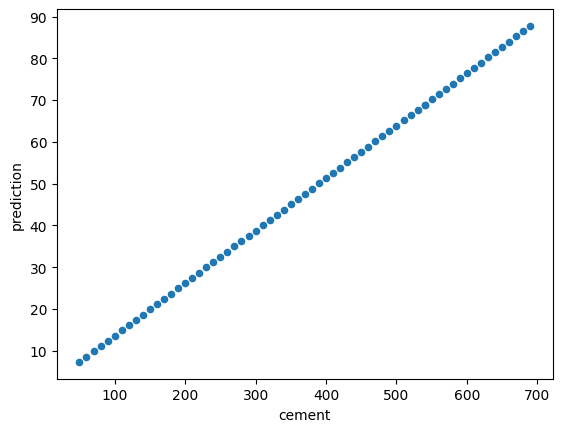

In [47]:
predictions.select(["cement", "prediction"]).toPandas().plot.scatter(
    x="cement",
    y="prediction",
)